In [1]:
%load_ext autoreload
%autoreload 2

import sys
print(sys.executable)

from pathlib import Path
import random
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
import tensorflow as tf
import pandas as pd
from utils import *
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Embedding, RNN, GRU, Bidirectional, Layer, Dropout
from tensorflow import keras
from tensorflow_probability import distributions
from tqdm.notebook import tqdm
from collections import defaultdict
import functools
import copy
from itertools import chain

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"tensorflow version: {tf.__version__}")
    
# TENSORFLOW 2 IS A PAIN IN THE ASS

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/bin/python


AttributeError: module 'tensorflow_core._api.v2.config' has no attribute 'gpu'

In [ ]:
dataset_4, dataset_64 = load_yoochoose_dataset_3()

train64, val64, test64 = dataset_64
train4, val4, test4 = dataset_4

train64, val64, test64 = contiguize_keys(train64, val64, test64)
train4, val4, test4 = contiguize_keys(train4, val4, test4)

train64_X, train64_y = train64
val64_X, val64_y = val64
test64_X, test64_y = test64
train4_X, train4_y = train4
val4_X, val4_y = val4
test4_X, test4_y = test4

In [ ]:
full_dataset = set()
for X, y in [train64, val64, test64, train4, val4, test4]:
    full_dataset |= set(chain.from_iterable(X))
    full_dataset |= set(y)

max_embedding_key = max(full_dataset)
for i in range(max_embedding_key):
    assert i in full_dataset

max_session_len = 0
for X, _ in [train64, val64, test64, train4, val4, test4]:
    max_session_len = max([len(sess) for sess in X])

print(f"max_embedding_key: {max_embedding_key}")
print(f"max_session_len: {max_session_len}")

In [4]:
def print_ds_statistics(dataset, ds_name):
    ds_X, ds_y = dataset
    print(f"{ds_name} len: {len(ds_X)}")
    print(f"num unique {ds_name}_X sessions: {len(np.unique(np.array(list(chain.from_iterable(ds_X))).flatten()))}")
    print(f"num unique {ds_name}_y sessions: {len(np.unique(np.array(ds_y).flatten()))}")

print_ds_statistics(train64, "train64")
print_ds_statistics(val64, "val64")
print_ds_statistics(test64, "test64")
print_ds_statistics(train4, "train4")
print_ds_statistics(val4, "val4")
print_ds_statistics(test4, "test4")

train64 len: 384464
num unique train64_X sessions: 16664
num unique train64_y sessions: 16722
val64 len: 45523
num unique val64_X sessions: 5475
num unique val64_y sessions: 5569
test64 len: 55415
num unique test64_X sessions: 5735
num unique test64_y sessions: 5863
train4 len: 6135750
num unique train4_X sessions: 29824
num unique train4_y sessions: 29745
val4 len: 45845
num unique val4_X sessions: 5711
num unique val4_y sessions: 5807
test4 len: 55863
num unique test4_X sessions: 6033
num unique test4_y sessions: 6155


In [5]:

# print(f"max_embedding_key: {max_embedding_key}")
# print(f"max_session_len: {max_session_len}")

# plt.hist([len(session) for session in dataset if len(session) < 20], bins=18)
# plt.xlabel("session length")
# plt.ylabel("ct")
# plt.title("count of session lengths < 20")
# plt.show()

# # dataset = dataset[:int(len(dataset)/4)]
# print(f"dataset len: {len(dataset)}")

# # removing click vs buy info
# dataset = [np.array([item[0] for item in session]) for session in dataset]

# # dataset = dataset[:int(len(dataset)/4)]
# print(f"trimmed dataset len: {len(dataset)}")

# (x_train,), (x_val,), (x_test,) = train_val_test_split(dataset, train_perc=.8, val_perc=.2, test_perc=0)

# print(Counter([len(session) for session in x_train if len(session) < 20]))
# plt.hist([len(session) for session in x_train if len(session) < 20], bins=18)
# plt.xlabel("session length")
# plt.ylabel("ct")
# plt.title("count of training session lengths < 20")
# plt.show()

# plt.hist([len(session) for session in x_val if len(session) < 20], bins=18)
# plt.xlabel("session length")
# plt.ylabel("ct")
# plt.title("count of validation lengths < 20")
# plt.show()

# print(f"{len(dataset)} examples")
# print(f"split into {len(x_train)} train, {len(x_val)} val, {len(x_test)} test")

# print(x_train[:200])
# print(x_val[:200])

In [6]:
"""
model notes:

Embedding layer:
    lower dimensional embedding + dropout

attention:
    given a variable length vector A of fixed length vectors, construct a fixed length vector where each element is the output of a tanh * sigmoid. the sigmoid is a gate on the tanh that determines how important that vector is A. Importance is calculated from sigmoid of the dot product between the vector with the trainable importance vector
    thus, attention is fundamentally a fully connected layer gated with sigmoid based on how similar the input is at that vector to the trainable importance vector.
    attention masking: 
        there is still the problem that the output of attention has to be a fixed length vector. 
        to do this, the goal is to pad the attention vector with zeros
        to do this, pad the output of u_{it}^T u_w with -infs so that the output of the softmax would be 0 and that these values won't affect the final ah

clustering:
    a softmax function with a stronger max
    take the inputs to clustering, pass them through a fully connected with the size of the output being the number of clusters, and hard softmax it. the hard softmax values will be the cluster that the vector belongs in. 

final attention layer on the clusters:
    do a softmax on the cluster embedding dot a importance vector and a softmax on the embedding dot the same importance vector. use those softmaxes to compute a weighted sum of the cluster embedding with the importance vector.

loss: 
    nce loss
"""
""

''

In [2]:
class GrumbelSoftmaxActivation(tf.keras.layers.Layer):
    def __init__(self, temp):
        super(GrumbelSoftmaxActivation, self).__init__()
        self.temp = temp
        self.gumbel = distributions.Gumbel(0, 1)
    
    def call(self, values):
        values = tf.nn.softmax(values, axis=1)
        grumbel_sample = self.gumbel.sample(values.shape)
        softmax_input = (tf.math.log(values)+grumbel_sample)/self.temp
        output = tf.nn.softmax(softmax_input, axis=1)
        return output

class LocalAttention(tf.keras.layers.Layer):
    
    def __init__(self, max_session_len, embedding_size):
        super(LocalAttention, self).__init__()

        print("max_session_len", max_session_len, "embedding_size", embedding_size)
        self.max_session_len = max_session_len
        self.embedding_size = embedding_size
    
        self.tanh_layer = Dense(
            self.embedding_size,
            activation='tanh',
            kernel_initializer='glorot_uniform',
            name="tanh_layer")
        
        u_shape = [self.embedding_size]
        self.u = self.add_weight("importance", shape=u_shape)

    def call(self, values, mask):
        batch_size, cur_session_len, item_shape = values.shape[0],values.shape[1],values.shape[2:]
        item_dims = len(item_shape)
        
        tanh_layer = self.tanh_layer(values)
        
        similarity_vector = tf.tensordot(tanh_layer, self.u, axes=([2], [0]))

        similarity_vector = similarity_vector+mask

        weights = tf.nn.softmax(similarity_vector, axis=1)
        
        values_transpose_axes = [i+2 for i in range(item_dims)]+[0, 1]
        inv_values_transpose_axes = [item_dims, item_dims+1]+[i for i in range(item_dims)]
        weighted_inputs = tf.transpose(
            tf.transpose(values, perm=values_transpose_axes)*weights,
            perm=inv_values_transpose_axes
        )
        output = tf.math.reduce_sum(weighted_inputs, axis=1)
        return output

class TestModel(Model):
    def __init__(self, max_embedding_key, max_session_len, embedding_size, gru_size, dense2_size, dense3_size, softmax_classes, temp):
        super(TestModel, self).__init__()
        self.max_embedding_key = max_embedding_key
        embedding_mtx_shape = [max_embedding_key, embedding_size]
        self.word_embedding_mtx = self.add_weight(
            initializer=tf.random_uniform_initializer(minval=-1, maxval=1), 
            shape=embedding_mtx_shape,
        )
        
        print("embedding_mtx_shape", embedding_mtx_shape)
        
        self.rnn = Bidirectional(GRU(gru_size, return_sequences=True), merge_mode="concat")
        self.attention1 = LocalAttention(max_session_len, gru_size)
        self.dense2 = Dense(
            dense2_size, 
            activation="linear", 
            kernel_initializer='he_normal'
        )
        self.dense2_act=tf.keras.layers.LeakyReLU()

        self.clustering = Dense(
            softmax_classes,
            activation="linear", 
            kernel_initializer='GlorotNormal'
        )
        self.clustering_act=GrumbelSoftmaxActivation(temp)
        self.clustering_map = Dense(
            embedding_size, 
            activation="linear", 
            kernel_initializer='he_normal'
        )
        self.clustering_map_act=tf.keras.layers.LeakyReLU()

        
        
        
        self.dense3 = Dense(
            dense3_size, 
            activation="linear", 
            kernel_initializer='he_normal'
        )

        self.dense3_act=tf.keras.layers.LeakyReLU()
        self.logits = Dense(
            max_embedding_key,
            activation="linear",
            kernel_initializer='GlorotNormal'
        )

    def call(self, x, mask, training=False):
        print("xshape", x.shape.as_list())
        word_embeddings = tf.nn.embedding_lookup(self.word_embedding_mtx, x)
        print("word_embeddings out", word_embeddings.shape.as_list())
        
        
        rnn_output = self.rnn(word_embeddings)
        print("rnn shape", rnn_output.shape.as_list())
        attention_output = self.attention1(rnn_output, mask)
        print("attention shape", attention_output.shape.as_list())

        
        if training:
            dense2 = Dropout(.5)(self.dense2_act(self.dense2(attention_output)))
            print("dense2 shape", dense2.shape.as_list())
            clusters = self.clustering_act(self.clustering(dense2))
            print("clusters shape", clusters.shape.as_list())
            clusterout = self.clustering_map_act(self.clustering_map(clusters))
            print("cluster shape", clusterout.shape.as_list())
            # cluster_att = tf.concat((word_embeddings, clusterout), axis=2)
            cluster_att = tf.concat((dense2, clusterout), axis=1)
            print("cluster_att shape", cluster_att.shape.as_list())

            dense3 = Dropout(.5)(self.dense3_act(self.dense3(cluster_att)))
            print("dense3 shape", dense3.shape.as_list())

            logits = self.logits(dense3)
            print("logits shape", logits.shape.as_list())

        else:
            dense2 = self.dense2_act(self.dense2(attention_output))
            clusters = self.clustering_act(self.clustering(dense2))
            clusterout = self.clustering_map_act(self.clustering_map(clusters))
            # cluster_att = tf.concat((word_embeddings, clusterout), axis=2)
            cluster_att = tf.concat((dense2, clusterout), axis=1)

            dense3 = self.dense3_act(self.dense3(cluster_att))

            logits = self.logits(dense3)
            
            noise = tf.random.uniform(logits.shape, maxval=10e-6)
            logits = logits + noise # adding the randomness cause topk categorical acc shitty
        
        softmax = tf.nn.softmax(logits)
        return logits, softmax
        
    def get_loss(self, y_true, logits):
        ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, logits)

        l1_reg = sum([tf.reduce_sum(tf.math.abs(tf.reshape(weight, [-1]))) for weight in self.trainable_variables])        
        num_trainable_variables = np.sum([np.prod(var.shape) for var in self.trainable_variables])
        l1_reg /= num_trainable_variables
        l1_reg *= 10
        loss = ce_loss+l1_reg
        return loss
    
    @tf.function
    def train_step(self, sessions, mask, labels, scores):
        with tf.GradientTape() as tape:
            logits, preds = self.call(sessions, mask, training=True)
            loss = self.get_loss(y_true=labels, logits=logits)
        gradients = tape.gradient(loss, model.trainable_variables)
        gradients = [tf.clip_by_value(grad, -1., 1.) for grad in gradients] # clip grads to stop nan problem
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        for score in scores:
            score.update_state(labels, tf.cast(preds, tf.float32))

        return preds

    @tf.function
    def test_step(self, sessions, mask, labels, scores):
        logits, preds = self.call(sessions, mask, training=False)
        for score in scores:
            score.update_state(labels, tf.cast(preds, tf.float32))
        return preds

In [25]:
print(max_embedding_key, max_session_len)
print(type(train64_X[0]))

48373 72
<class 'numpy.ndarray'>


In [ ]:
batch_size = 2048
print("batch_size", batch_size)

X_train, y_train = train4
X_val, y_val = val4
X_test, y_test = test4

model = TestModel(
    max_embedding_key=max_embedding_key, 
    max_session_len=max_session_len, 
    embedding_size=128,
    gru_size=128,
    dense2_size=512,
    dense3_size=256,
    softmax_classes=128,
    temp=.01
)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=.0003)

# train_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='train_loss')
train_accs = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20),
]
val_accs = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20),
]
test_accs = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20),
]

EPOCHS = 60
num_x = len(X_train)

train_accs_rec = defaultdict(lambda: [])
val_accs_rec = defaultdict(lambda: [])
test_accs_rec = defaultdict(lambda: [])
train_losses_rec = []
val_losses_rec = []

for epoch in tqdm(list(range(EPOCHS))):
    print(f"epoch {epoch}/{EPOCHS}")
    # Reset the metrics at the start of the next epoch
    for train_acc in train_accs:
        train_acc.reset_states()
    for val_acc in val_accs:
        val_acc.reset_states()
    for test_acc in test_accs:
        test_acc.reset_states()

    for X, y in tqdm(list(batchify(X_train, y_train, shuffle=True, batch_size=batch_size))):
        X, mask = mask_length(X, maskon_vals=0, maskoff_vals=-np.inf)
        model.train_step(tf.constant(X), tf.constant(mask), tf.constant(y), train_accs)

    for X, y in tqdm(list(batchify(X_val, y_val, shuffle=True, batch_size=batch_size))):
        X, mask = mask_length(X, maskon_vals=0, maskoff_vals=-np.inf)
        model.test_step(tf.constant(X), tf.constant(mask), tf.constant(y), val_accs)

    topn_labels = ["acc", "top5 acc", "top10 acc", "top20 acc"]
    for label, train_acc, val_acc in zip(topn_labels, train_accs, val_accs):
        train_accs_rec[label].append(train_acc.result())
        val_accs_rec[label].append(val_acc.result())
        print(f"{label} train: {train_acc.result()}")
        print(f"{label} val: {val_acc.result()}")

    print(f"Epoch {epoch+1}")

batch_size 2048
embedding_mtx_shape [48373, 128]
max_session_len 72 embedding_size 128


epoch 0/60


xshape [2048, 84]
word_embeddings out [2048, 84, 128]
rnn shape [2048, 84, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 84]
word_embeddings out [2048, 84, 128]
rnn shape [2048, 84, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 160]
word_embeddings out [2048, 160, 128]
rnn shape [2048, 160, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 156]
word_embeddings out [2048, 156, 128]
rnn shape [2048, 156, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 96]
word_embeddings out [2048, 96, 128]
rnn shape [2048, 96, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 180]
word_embeddings out [2048, 180, 128]
rnn shape [2048, 180, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 144]
word_embeddings out [2048, 144, 128]
rnn shape [2048, 144, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 168]
word_embeddings out [2048, 168, 128]
rnn shape [2048, 168, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 120]
word_embeddings out [2048, 120, 128]
rnn shape [2048, 120, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 80]
word_embeddings out [2048, 80, 128]
rnn shape [2048, 80, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 88]
word_embeddings out [2048, 88, 128]
rnn shape [2048, 88, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 112]
word_embeddings out [2048, 112, 128]
rnn shape [2048, 112, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 92]
word_embeddings out [2048, 92, 128]
rnn shape [2048, 92, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 172]
word_embeddings out [2048, 172, 128]
rnn shape [2048, 172, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 108]
word_embeddings out [2048, 108, 128]
rnn shape [2048, 108, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 176]
word_embeddings out [2048, 176, 128]
rnn shape [2048, 176, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 116]
word_embeddings out [2048, 116, 128]
rnn shape [2048, 116, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 152]
word_embeddings out [2048, 152, 128]
rnn shape [2048, 152, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 140]
word_embeddings out [2048, 140, 128]
rnn shape [2048, 140, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 100]
word_embeddings out [2048, 100, 128]
rnn shape [2048, 100, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 136]
word_embeddings out [2048, 136, 128]
rnn shape [2048, 136, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 60]
word_embeddings out [2048, 60, 128]
rnn shape [2048, 60, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 164]
word_embeddings out [2048, 164, 128]
rnn shape [2048, 164, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 188]
word_embeddings out [2048, 188, 128]
rnn shape [2048, 188, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 124]
word_embeddings out [2048, 124, 128]
rnn shape [2048, 124, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 148]
word_embeddings out [2048, 148, 128]
rnn shape [2048, 148, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 128]
word_embeddings out [2048, 128, 128]
rnn shape [2048, 128, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 192]
word_embeddings out [2048, 192, 128]
rnn shape [2048, 192, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 196]
word_embeddings out [2048, 196, 128]
rnn shape [2048, 196, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 132]
word_embeddings out [2048, 132, 128]
rnn shape [2048, 132, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 104]
word_embeddings out [2048, 104, 128]
rnn shape [2048, 104, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 184]
word_embeddings out [2048, 184, 128]
rnn shape [2048, 184, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 68]
word_embeddings out [2048, 68, 128]
rnn shape [2048, 68, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 200]
word_embeddings out [2048, 200, 128]
rnn shape [2048, 200, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 76]
word_embeddings out [2048, 76, 128]
rnn shape [2048, 76, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 72]
word_embeddings out [2048, 72, 128]
rnn shape [2048, 72, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 64]
word_embeddings out [2048, 64, 128]
rnn shape [2048, 64, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 56]
word_embeddings out [2048, 56, 128]
rnn shape [2048, 56, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 52]
word_embeddings out [2048, 52, 128]
rnn shape [2048, 52, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [1990, 144]
word_embeddings out [1990, 144, 128]
rnn shape [1990, 144, 256]
attention shape [1990, 256]
dense2 shape [1990, 512]
clusters shape [1990, 128]
cluster shape [1990, 128]
cluster_att shape [1990, 640]
dense3 shape [1990, 256]
logits shape [1990, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 72]
word_embeddings out [2048, 72, 128]
rnn shape [2048, 72, 256]
attention shape [2048, 256]
xshape [2048, 92]
word_embeddings out [2048, 92, 128]
rnn shape [2048, 92, 256]
attention shape [2048, 256]
xshape [2048, 84]
word_embeddings out [2048, 84, 128]
rnn shape [2048, 84, 256]
attention shape [2048, 256]
xshape [2048, 60]
word_embeddings out [2048, 60, 128]
rnn shape [2048, 60, 256]
attention shape [2048, 256]
xshape [2048, 88]
word_embeddings out [2048, 88, 128]
rnn shape [2048, 88, 256]
attention shape [2048, 256]
xshape [2048, 80]
word_embeddings out [2048, 80, 128]
rnn shape [2048, 80, 256]
attention shape [2048, 256]
xshape [2048, 76]
word_embeddings out [2048, 76, 128]
rnn shape [2048, 76, 256]
attention shape [2048, 256]
xshape [2048, 96]
word_embeddings out [2048, 96, 128]
rnn shape [2048, 96, 256]
attention shape [2048, 256]
xshape [789, 76]
word_embeddings out [789, 76, 128]
rnn shape [789, 76, 256]
attention shape [789, 256]

acc train: 0.14749591052532196


xshape [2048, 48]
word_embeddings out [2048, 48, 128]
rnn shape [2048, 48, 256]
attention shape [2048, 256]
dense2 shape [2048, 512]
clusters shape [2048, 128]
cluster shape [2048, 128]
cluster_att shape [2048, 640]
dense3 shape [2048, 256]
logits shape [2048, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 68]
word_embeddings out [2048, 68, 128]
rnn shape [2048, 68, 256]
attention shape [2048, 256]
xshape [789, 84]
word_embeddings out [789, 84, 128]
rnn shape [789, 84, 256]
attention shape [789, 256]

acc train: 0.1848083734512329
acc val: 0.16946232318878174
top5 acc train: 0.4680459499359131
top5 acc val: 0.4323045015335083
top10 acc train: 0.5862156748771667
top10 acc val: 0.541520357131958
top20 acc train: 0.6701149940490723
top20 acc val: 0.6365579962730408
Epoch 2
epoch 2/60


xshape [1990, 100]
word_embeddings out [1990, 100, 128]
rnn shape [1990, 100, 256]
attention shape [1990, 256]
dense2 shape [1990, 512]
clusters shape [1990, 128]
cluster shape [1990, 128]
cluster_att shape [1990, 640]
dense3 shape [1990, 256]
logits shape [1990, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [789, 64]
word_embeddings out [789, 64, 128]
rnn shape [789, 64, 256]
attention shape [789, 256]

acc train: 0.18956150114536285
acc val: 0.16821900010108948
top5 acc train: 0.48212558031082153
top5 acc val: 0.4301668703556061
top10 acc train: 0.6035236120223999
top10 acc val: 0.5454902648925781
top20 acc train: 0.6892510056495667
top20 acc val: 0.6426218748092651
Epoch 3
epoch 3/60


xshape [1990, 108]
word_embeddings out [1990, 108, 128]
rnn shape [1990, 108, 256]
attention shape [1990, 256]
dense2 shape [1990, 512]
clusters shape [1990, 128]
cluster shape [1990, 128]
cluster_att shape [1990, 640]
dense3 shape [1990, 256]
logits shape [1990, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



acc train: 0.19311657547950745
acc val: 0.17576617002487183
top5 acc train: 0.48850131034851074
top5 acc val: 0.4525902569293976
top10 acc train: 0.6109645962715149
top10 acc val: 0.5699421763420105
top20 acc train: 0.6972624659538269
top20 acc val: 0.6663103699684143
Epoch 4
epoch 4/60


xshape [1990, 184]
word_embeddings out [1990, 184, 128]
rnn shape [1990, 184, 256]
attention shape [1990, 256]
dense2 shape [1990, 512]
clusters shape [1990, 128]
cluster shape [1990, 128]
cluster_att shape [1990, 640]
dense3 shape [1990, 256]
logits shape [1990, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [789, 56]
word_embeddings out [789, 56, 128]
rnn shape [789, 56, 256]
attention shape [789, 256]

acc train: 0.19429703056812286
acc val: 0.17855818569660187
top5 acc train: 0.4928346276283264
top5 acc val: 0.45562219619750977
top10 acc train: 0.6164240837097168
top10 acc val: 0.573737621307373
top20 acc train: 0.7033454775810242
top20 acc val: 0.6694077849388123
Epoch 5
epoch 5/60


xshape [1990, 84]
word_embeddings out [1990, 84, 128]
rnn shape [1990, 84, 256]
attention shape [1990, 256]
dense2 shape [1990, 512]
clusters shape [1990, 128]
cluster shape [1990, 128]
cluster_att shape [1990, 640]
dense3 shape [1990, 256]
logits shape [1990, 48373]


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


xshape [2048, 64]
word_embeddings out [2048, 64, 128]
rnn shape [2048, 64, 256]
attention shape [2048, 256]
xshape [789, 68]
word_embeddings out [789, 68, 128]
rnn shape [789, 68, 256]
attention shape [789, 256]

acc train: 0.19536112248897552
acc val: 0.1776638627052307
top5 acc train: 0.49398019909858704
top5 acc val: 0.4579997956752777
top10 acc train: 0.6176749467849731
top10 acc val: 0.5758970379829407
top20 acc train: 0.7049247622489929
top20 acc val: 0.6741192936897278
Epoch 6
epoch 6/60


In [43]:
for test_acc in test_accs:
    test_acc.reset_states()

predictions = []
ys = []
for X, y in tqdm(list(batchify(X_test, y_test, shuffle=True, batch_size=batch_size))):
    X, mask = mask_length(X, maskon_vals=0, maskoff_vals=-np.inf)
    topn_labels = ["acc", "top5 acc", "top10 acc", "top20 acc"]
    predictions.append(model.test_step(tf.constant(X), tf.constant(mask), tf.constant(y), test_accs).numpy())
    ys.append(y)

for label, test_acc in zip(topn_labels, test_accs):
    print(label)
    print(test_acc.result())

print("computing mrr:")
mrr_num = 0
mrr_denom = 0
for i in tqdm(range(len(predictions))):
    for j in range(len(predictions[i])):
        yvalue  = ys[i][j]
        if yvalue in ((-predictions[i][j]).argsort()[:20]):
            mrr_num += 1/(1+np.argwhere(yvalue == ((-predictions[i][j]).argsort()[:20]))[0, 0])
        mrr_denom += 1

print(mrr_num/mrr_denom)

xshape [2048, 56]
word_embeddings out [2048, 56, 64]
clusters shape [2048, 56, 64]
cluster shape [2048, 56, 64]
cluster_att shape [2048, 56, 128]
rnn shape [2048, 56, 128]
attention shape [2048, 128]
dense2 shape [2048, 256]
dense3 shape [2048, 128]
logits shape [2048, 48373]
xshape [2048, 68]
word_embeddings out [2048, 68, 64]
clusters shape [2048, 68, 64]
cluster shape [2048, 68, 64]
cluster_att shape [2048, 68, 128]
rnn shape [2048, 68, 128]
attention shape [2048, 128]
dense2 shape [2048, 256]
dense3 shape [2048, 128]
logits shape [2048, 48373]
xshape [2048, 60]
word_embeddings out [2048, 60, 64]
clusters shape [2048, 60, 64]
cluster shape [2048, 60, 64]
cluster_att shape [2048, 60, 128]
rnn shape [2048, 60, 128]
attention shape [2048, 128]
dense2 shape [2048, 256]
dense3 shape [2048, 128]
logits shape [2048, 48373]
xshape [2048, 64]
word_embeddings out [2048, 64, 64]
clusters shape [2048, 64, 64]
cluster shape [2048, 64, 64]
cluster_att shape [2048, 64, 128]
rnn shape [2048, 64, 12


0.28287416073565874


In [149]:
# print(predictions)
# print(y)




0.28202081202707663


In [ ]:
num = 0
denom = 0
for i, sess in enumerate(x_val):
    y = sess[-1]
    x = sess[:-1]
    xs, masks = mask_length([x], maskon_vals=0, maskoff_vals=-np.inf)
    
    [logit], [pred] = model.call(xs, masks)
    logit = logit.numpy()
    print(y, np.argsort(pred.numpy())[-1:])
    if y in np.argsort(pred.numpy())[-1:]:
        num += 1
    denom += 1
    if i % 20 == 1:
        print("ACC", num/denom)
#     print(len(pred[0]))
#     print(sum(pred[0].numpy()==0))
    
#     print(sum(pred[0] * (pred[0] != 0)))
#     print(y, np.argpartition(pred[0], -1)[:-1])

In [112]:
import os
os.mkdir("58_acc_76_top5_85_top50.tf_save")
model.save_weights("58_acc_76_top5_85_top50.tf_save/model")

AttributeError: 'NoneType' object has no attribute 'replace'

In [6]:
# record experiment scores
import datetime

with open("last_expr_name.txt", "r+") as last_expr_name:
    try:
        last_expr_name = int(last_expr_name.read())+1
    except:
        last_expr_name = 0
with open("last_expr_name.txt", "w") as expr_names:
    expr_names.write(str(last_expr_name))

experiment_name = f"expr{last_expr_name}_{datetime.date.today()}"

import os
expr_dir = Path("records")/experiment_name
(expr_dir/"model").mkdir(parents=True, exist_ok=True)

print("saving at", str(expr_dir/"model/model"))
# model.save_weights(str(expr_dir/"model/model"))

topn_labels = ["acc", "top5 acc", "top10 acc", "top20 acc", "top50 acc"]
train_accs = [train_accs_rec[label] for label in topn_labels]
test_accs = [test_accs_rec[label] for label in topn_labels]
for label, train_acc, test_acc in zip(topn_labels, train_accs, test_accs):
    kwargs = {
        "title": f"test {label}",
        "xlabel": "epoch",
        "ylabel": label
    }
    save_accs(expr_dir/"scores", [test_acc], kwargs)
    
    kwargs = {
        "title": f"train {label}",
        "xlabel": "epoch",
        "ylabel": label
    }
    save_accs(expr_dir/"scores", [train_acc], kwargs)
    
kwargs = {
    "title": f"test accs",
    "xlabel": "epoch",
    "ylabel": "acc",
    "legend": topn_labels
}
save_accs(expr_dir/"scores", test_accs, kwargs)


with open(expr_dir/"scores"/"raw_scores.pickle", "wb+") as raw_scores_handle:
    scores = {}
    for label in topn_labels:
        scores[f"train {label}"] = train_accs_rec[label]
        scores[f"test {label}"] = test_accs_rec[label]
    pickle.dump(scores, raw_scores_handle)
    


SyntaxError: invalid syntax (<ipython-input-6-08255273a46b>, line 55)

In [123]:
print(model.dense3.weights[0].shape)
print(model.dense3.weights[1].shape)

(512, 128)
(128,)


In [106]:
# whole model graph
from graphviz import Digraph
graphs_dir = Path("graphs")
graphs_dir.mkdir(exist_ok="True")

dot = Digraph(comment="model", format="png")
dot.attr(pad=".1", ranksep="0.25", nodesep="0.25")
# dot.attr(color='black')
# dot.attr(style='filled', color='grey64')
# dot.node_attr['style'] = 'filled'
dot.attr(label='E2E CSRS')
dot.attr(labelloc="t")
dot.attr(bgcolor='grey64')

#     dp.attr(color='black')
#     dp.attr(style='filled', color='grey64')
#     dp.node_attr['style'] = 'filled'
#     dp.attr(label='E2E SRS')

dot.node('K', 'Output', shape="box", width="3", height=".3", fillcolor="grey80", style="filled")
dot.node('J', 'FC-softmax', shape="box", width="3", height=".3", fillcolor="grey80", style="filled")
dot.node('I', 'FC-leaky relu', shape="box", width="3", height=".3", fillcolor="grey80", style="filled")
dot.node('H', 'Concat', shape="box", width="3", fillcolor="grey80", height=".3", style="filled")
dot.node('G', 'FC-leaky relu', shape="box", width="2", height=".3", fillcolor="grey80", style="filled")
dot.node('F', 'FC-grumbel softmax', shape="box", width="2", height=".3", fillcolor="grey80", style="filled")
dot.node('E', 'FC-leaky relu', shape="box", width="3", height=".3", fillcolor="grey80", style="filled")
dot.node('D', 'Attention1', shape="box", width="3", height=".3", fillcolor="grey80", style="filled")
dot.node('C', 'Bidirectional GRU', shape="box", width="3", height=".3", fillcolor="grey80", style="filled")
dot.node('B', 'Embedding', shape="box", width="3", height=".3", fillcolor="grey80", style="filled")
dot.node('A', 'Input', shape="box", width="3", height=".3", fillcolor="grey80", style="filled")
dot.edge("K", "J", dir="back")
dot.edge("J", "I", dir="back")
dot.edge("I", "H", dir="back")
dot.edge("H", "G", dir="back")
dot.edge("G", "F", dir="back")
dot.edge("F", "E", dir="back")
dot.edge("H", "E", dir="back")
dot.edge("E", "D", dir="back")
dot.edge("D", "C", dir="back")
dot.edge("C", "B", dir="back")
dot.edge("B", "A", dir="back")
dot.render(graphs_dir/'model')

# attention layer graph
graphs_dir = Path("graphs")
graphs_dir.mkdir(exist_ok="True")

dot = Digraph(comment="bahdanau_attention", format="png")
dot.attr(pad=".1", ranksep="0.25", nodesep="0.25")
dot.attr(labelloc="t")
dot.attr(bgcolor='grey64')
dot.attr(label='Bahdanau Attention')

dot.node('F', 'Output', shape="box", width="2", height=".3", fillcolor="grey80", style="filled")
dot.node('E', 'Product', shape="box", width="2", height=".3", fillcolor="grey80", style="filled")
dot.node('D', 'Softmax', shape="box", width="2", height=".3", fillcolor="grey80", style="filled")
dot.node('Ca', 'Sum', shape="box", width="2", height=".3", fillcolor="grey80", style="filled")
dot.node('C', 'Dot product', shape="box", width="2", height=".3", fillcolor="grey80", style="filled")
with dot.subgraph() as dpp:
    dpp.node("asdf", "", style="invis")
    dpp.node('B2', 'Context Vectors', shape="box", width="2", height=".3", fillcolor="grey80", style="filled")
    dpp.node('B1', 'FC-tanh', shape="box", width="2", height=".3", fillcolor="grey80", style="filled")
with dot.subgraph() as dpp:
    dpp.attr(rank='same')
    dpp.node('A', 'Input', shape="box", width="2", height=".3", fillcolor="grey80", style="filled")
    dpp.node('0A', 'Mask', shape="box", width="2", height=".3", fillcolor="grey80", style="filled")


dot.edge("F", "E", dir="back")
dot.edge("E", "D", dir="back")
dot.edge("D", "Ca", dir="back")
dot.edge("Ca", "C", dir="back")
dot.edge("C", "B1", dir="back")
dot.edge("C", "B2", dir="back")
dot.edge("E", "A", dir="back")
dot.edge("B1", "A", dir="back")
dot.edge("Ca", "0A", dir="back")
dot.render(graphs_dir/'bahdanau_attention')


# grumbel softmax

graphs_dir = Path("graphs")
graphs_dir.mkdir(exist_ok="True")

dot = Digraph(comment="Grumbel_Softmax", format="png")
dot.attr(pad=".1", ranksep="0.25", nodesep="0.25")
dot.attr(labelloc="t")
dot.attr(bgcolor='grey64')
dot.attr(color='black')
dot.attr(style='filled', color='grey64')
dot.node_attr["width"]="3"
dot.node_attr['style'] = 'filled'
dot.attr(label='Grumbel Softmax')

dot.node('F', 'Softmax', shape="box", width="2", height=".3")
dot.node('E', 'x/τ', shape="box", width="2", height=".3")
dot.node('D', 'Sum', shape="box", width="2", height=".3")
dot.node('C2', 'Grumbel random sample', shape="box", width="2", height=".3")
dot.node('C1', 'Log(x)', shape="box", width="2", height=".3")
dot.node('B', 'Softmax', shape="box", width="2", height=".3")

dot.node('A', 'Input', shape="box", width="2", height=".3")
dot.edge("F", "E", dir="back")
dot.edge("E", "D", dir="back")
dot.edge("D", "C2", dir="back")
dot.edge("D", "C1", dir="back")
dot.edge("C1", "B", dir="back")
dot.edge("B", "A", dir="back")
dot.render(graphs_dir/'grumbel_softmax')

'graphs/grumbel_softmax.png'

In [11]:
nums = defaultdict(lambda: 0)
denoms = defaultdict(lambda: 0)
for i, sess in tqdm(list(enumerate(x_val[:5000]))):
    y = sess[-1]
    x = sess[:-1]
    xs, masks = mask_length([x], maskon_vals=0, maskoff_vals=-np.inf)

    [logit], [pred] = model.call(xs, masks)
    logit = logit.numpy()
    print(y, np.argsort(pred.numpy())[-1:])
    if y in np.argsort(pred.numpy())[-1:]:
        nums[len(x)] += 1
    denoms[len(x)] += 1

xs = sorted(nums.keys())
accs = [nums[i]/denoms[i] for i in xs]
®
plt.bar(x=xs, height=accs)
plt.title("top1 accs by session length")
plt.xlabel("session length")
plt.ylabel("top1 acc")
plt.save("")

45783 [45223]
3543 [3543]
21378 [21378]
931 [931]
251 [14284]
33047 [33047]
45251 [45251]
51070 [51070]
162 [873]
14343 [35108]
2285 [2285]
34818 [34818]
175 [156]
44095 [44095]
43174 [43153]
33047 [33047]
974 [51079]
37877 [44094]
31284 [31284]
7654 [43226]
31197 [31197]
39247 [41465]
1109 [1109]
3746 [3746]
56 [56]
49304 [49304]
37906 [37906]
46353 [46353]
49276 [12594]
44132 [44132]
28326 [28326]
2110 [2110]
50341 [49214]
45787 [51079]
36718 [36718]
47624 [1056]
34813 [3667]
28327 [28327]
1251 [46919]
46314 [46314]
49095 [49082]
9465 [28327]
162 [162]
20423 [20]
1826 [50302]
874 [874]
867 [867]
41570 [41570]
44590 [44590]
49104 [49093]
780 [780]
88 [88]
31042 [32209]
37874 [37874]
5209 [1946]
940 [940]
36718 [36718]
23117 [23117]
12449 [50311]
37918 [37881]
14519 [14519]
51074 [51074]
92 [92]
43207 [42456]
8677 [31042]
5823 [5823]
48251 [48251]
33033 [33033]
283 [4096]
44270 [44270]
49304 [49304]
738 [25472]
5160 [5160]
522 [522]
33047 [33047]
976 [976]
88 [88]
7426 [2150]
48278 [51

33078 [3247]
33047 [33047]
51070 [51070]
45212 [45212]
9246 [50341]
2913 [2913]
48286 [48286]
33047 [33047]
286 [286]
23135 [23135]
88 [88]
340 [409]
3381 [544]
203 [203]
459 [459]
39338 [32209]
11534 [11534]
1136 [172]
49304 [49304]
48311 [48256]
666 [41475]
47585 [50325]
51735 [51699]
40670 [40654]
48255 [33029]
3724 [3724]
33047 [33047]
7224 [44084]
46298 [22230]
8453 [8453]
127 [31654]
748 [28327]
23065 [23065]
2981 [88]
2957 [19897]
10915 [10915]
45215 [45215]
51119 [51119]
49150 [952]
5062 [39263]
43169 [43169]
51096 [49082]
4033 [4033]
202 [975]
45213 [45213]
45764 [45826]
47060 [47060]
26266 [26265]
144 [144]
48279 [48279]
16108 [16108]
89 [8]
45213 [45213]
33029 [32209]
40661 [40661]
6519 [5691]
42846 [43185]
45814 [45814]
46910 [46915]
46353 [46353]
23163 [23163]
3417 [7847]
5493 [23090]
42463 [42463]
44114 [44114]
867 [144]
997 [997]
45863 [45863]
4675 [34819]
23090 [23090]
49106 [51700]
330 [330]
38005 [28340]
90 [90]
44963 [44963]
5785 [7779]
44618 [44606]
878 [878]
23090 

11590 [5006]
48256 [48279]
33029 [33029]
46979 [46979]
15006 [42447]
3428 [705]
42484 [672]
28323 [23163]
39240 [42843]
131 [609]
23086 [160]
47487 [47484]
1681 [1681]
10715 [10715]
36447 [36447]
43187 [43187]
33032 [31042]
3504 [46352]
44588 [44588]
41446 [39277]
45232 [45232]
1782 [1782]
88 [88]
33113 [3139]
23342 [23108]
21356 [21356]
26326 [26326]
39275 [39275]
45257 [3843]
43186 [43186]
40758 [40758]
972 [972]
23103 [23103]
172 [488]
51085 [51085]
1136 [37880]
2004 [23192]
50304 [49127]
40676 [40676]
45766 [3034]
39248 [39248]
609 [23077]
33047 [33047]
37894 [37894]
46336 [46343]
42439 [42450]
46353 [46353]
34817 [1068]
30930 [30930]
916 [916]
30790 [30790]
202 [202]
23643 [28339]
1000 [340]
39278 [39278]
529 [529]
42473 [42473]
1515 [1515]
298 [298]
7752 [7752]
40681 [40681]
12891 [42463]
28323 [28323]
1614 [1614]
50306 [50306]
1413 [1413]
45857 [45857]
572 [572]
34818 [34818]
46422 [46375]
39270 [2859]
28363 [26266]
244 [34814]
9319 [28326]
5817 [56]
44121 [43150]
33047 [33047]


4044 [4044]
37965 [37965]
39284 [39284]
48282 [41570]
39252 [39252]
161 [28381]
37909 [37909]
24266 [6397]
23082 [23082]
787 [787]
17644 [17644]
45758 [48258]
224 [224]
91 [91]
156 [146]
43206 [43200]
26 [164]
377 [5536]
33047 [33047]
842 [842]
46314 [46314]
43152 [48273]
37928 [14]
4633 [4633]
28323 [28323]
49098 [49098]
2328 [2328]
44963 [45214]
28418 [28418]
298 [298]
459 [247]
46905 [46905]
44088 [44088]
49091 [49091]
801 [156]
36432 [34817]
484 [484]
961 [2488]
45325 [45325]
30763 [30773]
45791 [45791]
48311 [842]
30745 [28615]
2160 [1152]
10771 [1171]
50305 [50291]
23081 [23081]
6768 [34813]
46925 [46925]
120 [120]
2100 [2100]
33047 [33047]
9689 [9689]
20423 [53]
1954 [43191]
997 [997]
42446 [45254]
333 [333]
286 [39273]
51234 [51699]
2234 [2234]
41467 [30930]
35 [35]
42475 [42475]
44082 [43153]
11708 [36472]
94 [94]
216 [914]
1759 [47682]
45374 [45374]
514 [514]
354 [355]
45785 [45785]
33047 [33047]
49081 [49113]
49116 [49094]
1316 [1122]
4640 [4640]
48279 [48279]
45777 [45777]


33047 [33047]
36718 [37906]
3080 [3080]
719 [115]
609 [609]
89 [89]
35074 [35074]
904 [11825]
46294 [45993]
36414 [36414]
47057 [47505]
41475 [41475]
47477 [47496]
46323 [46323]
23141 [247]
33047 [33047]
1134 [42450]
3007 [3007]
2870 [2870]
1988 [23092]
13474 [4300]
15360 [15360]
1182 [1701]
43175 [43175]
42544 [42544]
28340 [28340]
49139 [49139]
28324 [28324]
36924 [36924]
45273 [33025]
47494 [47495]
47503 [47503]
44131 [37877]
36718 [37882]
9869 [30790]
22523 [18729]
45223 [1468]
11197 [44635]
45223 [45223]
1457 [1457]
30790 [30790]
37909 [37909]
15 [15]
728 [7752]
523 [41458]
330 [12594]
13461 [1494]
6538 [6538]
13829 [23643]
44633 [28364]
13331 [13331]
42489 [42448]
49081 [49125]
51724 [46923]
2853 [165]
3593 [3593]
19717 [19717]
45779 [43153]
1979 [1979]
1781 [1781]
1000 [1000]
48274 [48274]
23953 [47496]
4526 [1733]
45772 [45764]
44618 [44618]
3756 [1084]
730 [730]
65 [65]
50292 [50303]
361 [361]
47059 [47472]
48273 [44662]
48278 [48278]
17317 [17317]
4412 [4411]
728 [728]
33028 

37896 [37889]
49137 [49137]
47604 [47604]
14 [14]
43267 [43267]
1222 [1222]
28349 [23643]
867 [867]
44618 [44579]
50353 [50332]
41455 [41455]
6425 [6425]
44069 [6420]
50323 [50323]
6283 [6283]
605 [605]
5445 [5445]
28381 [28381]
51753 [46912]
787 [787]
33368 [40655]
36424 [36465]
1147 [6420]
204 [204]
33047 [33047]
4446 [902]
874 [402]
40663 [40663]
48254 [48254]
51090 [32187]
34832 [2870]
37900 [37897]
6420 [46353]
48265 [45764]
30 [30]
6726 [28660]
8270 [7251]
28345 [28345]
210 [210]
15510 [17492]
2021 [30781]
539 [539]
204 [204]
210 [210]
7916 [13304]
147 [147]
47471 [47471]
409 [409]
51138 [51100]
51081 [51081]
455 [455]
7236 [728]
28323 [45]
42470 [42448]
30930 [30930]
33047 [33042]
45254 [45212]
45325 [45993]
28647 [29311]
2859 [2859]
4675 [4675]
172 [28330]
42454 [42454]
31126 [3475]
30752 [408]
48286 [48286]
12681 [12681]
471 [471]
31141 [31141]
44583 [47493]
45758 [48258]
50317 [50291]
50312 [50312]
2091 [2091]
34811 [34818]
33047 [33047]
11758 [6257]
46893 [46299]
45777 [4575

28425 [28364]
42606 [2097]
330 [88]
5833 [5833]
5256 [5256]
45272 [45272]
632 [34814]
44147 [23114]
934 [33028]
42553 [42463]
6237 [7297]
47059 [47059]
46903 [46903]
4638 [39378]
32209 [30930]
1346 [1346]
3593 [3593]
48275 [47520]
9571 [46353]
738 [738]
6477 [7594]
19735 [23217]
37911 [37911]
45760 [42438]
26264 [26263]
1215 [1652]
2212 [164]
48279 [48279]
48265 [48265]
49091 [49091]
50341 [50332]
3271 [3271]
7038 [23678]
39262 [39284]
51073 [51119]
40678 [420]
20638 [1972]
9320 [802]
961 [26266]
17220 [3235]
5156 [12724]
41570 [41570]
144 [144]
23131 [23131]
47493 [47493]
1661 [1661]
6073 [30639]
544 [544]
47505 [47505]
46895 [46895]
9359 [7929]
46306 [46306]
39378 [39378]
144 [144]
46903 [46903]
30865 [30865]
13264 [14673]
12724 [12724]
45237 [6420]
44084 [15317]
49178 [49178]
28323 [45863]
34817 [34814]
33704 [28334]
544 [544]
45218 [45218]
1146 [1146]
1659 [1659]
27634 [42447]
47546 [43182]
1806 [1368]
4849 [210]
45080 [47474]
33047 [33047]
9730 [6380]
43187 [43187]
37890 [37890]
4

1308 [23643]
11621 [47473]
40654 [40659]
47 [36433]
6380 [6380]
30309 [30309]
13461 [46353]
42463 [42463]
10666 [1029]
42443 [40654]
2127 [23120]
3955 [3955]
36460 [36460]
5427 [392]
46294 [45993]
48274 [48274]
299 [299]
46294 [46296]
5385 [3543]
47508 [40676]
5398 [5385]
679 [49095]
244 [244]
28346 [30]
202 [202]
44733 [39392]
3720 [3720]
12724 [12724]
317 [317]
23109 [23109]
437 [437]
904 [41487]
50324 [50324]
33047 [33047]
37897 [37897]
380 [1150]
37891 [37891]
51070 [51070]
46353 [46353]
2444 [11309]
2360 [2359]
1979 [39256]
167 [14]
28349 [28349]
48295 [48295]
4023 [4023]
4594 [3464]
51207 [31932]
37872 [43]
23163 [28362]
51234 [51700]
33047 [33047]
1150 [1150]
36548 [36548]
15091 [132]
37944 [37944]
1823 [1823]
23160 [2673]
904 [904]
34820 [4675]
705 [705]
49100 [49122]
28339 [28339]
88 [160]
23090 [23090]
34850 [43188]
24768 [1016]
7791 [7791]
47512 [47512]
47470 [47472]
23643 [23643]
8558 [4310]
6380 [6380]
47661 [12085]
12588 [1767]
44586 [915]
50296 [50299]
44270 [44270]
257 

TypeError: bar() missing 1 required positional argument: 'height'

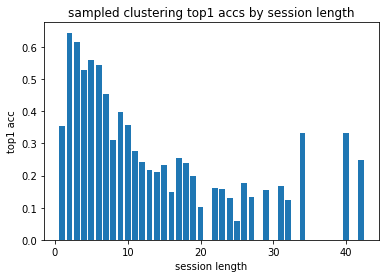

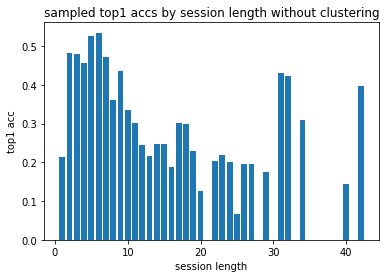

Text(0, 0.5, 'count')

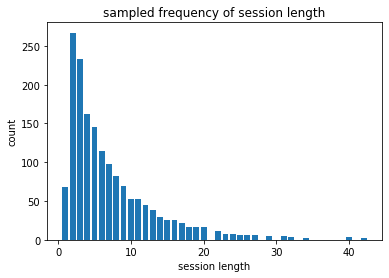

In [100]:
plt.bar(x=xs, height=np.array(accs))
# plt.bar(x=xs, height=(accs+np.random.uniform(.05, size=len(xs)))/2)
plt.title("sampled clustering top1 accs by session length")
plt.xlabel("session length")
plt.ylabel("top1 acc")
plt.show()
plt.clf()

plt.bar(x=xs, height=np.array(accs_no_cluster))
plt.title("sampled top1 accs by session length without clustering")
plt.xlabel("session length")
plt.ylabel("top1 acc")
plt.show()
plt.clf()

plt.bar(x=xs, height=[int(denoms[x]) for x in xs])
# plt.bar(x=xs, height=(accs+np.random.uniform(.05, size=len(xs)))/2)
plt.title("sampled frequency of session length")
plt.xlabel("session length")
plt.ylabel("count")


# class GrumbelSoftmaxActivation(tf.keras.layers.Layer):
#     def __init__(self, temp):
#         super(GrumbelSoftmaxActivation, self).__init__()
#         self.temp = temp
#         self.gumbel = distributions.Gumbel(0, 1)
    
# #     def build(self, input_shape):
#     def call(self, values):
#         values = tf.nn.softmax(values, axis=1)
# #         print("values", values.shape)
#         grumbel_sample = self.gumbel.sample(values.shape)
# #         tf.print(grumbel_sample)
#         softmax_input = (tf.math.log(values)+grumbel_sample)/self.temp
#         output = tf.nn.softmax(softmax_input, axis=1)
# #         print("output", output.shape)
#         return output


In [42]:
# with tf.Session() as sess:
#     y_true = tf.placeholder(dtype=tf.float64, shape=[None, 1])

#     learning_rate=.001
#     epochs=60
#     ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
#     train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(ce_loss_term)

#     sess.run(tf.global_variables_initializer())

#     for epoch in tqdm(range(epochs), leave=False):
#         print("epoch", epoch)
#         print("training")
#         for b_Xs, b_ys in batchify(train_Xs, train_ys, batch_size=746661):
#             session_idxs, item_idxs = b_Xs.T
#             feed_dict = {session_slice_idxs: session_idxs, 
#                         item_slice_idxs: item_idxs, 
#                         y_true: b_ys}
#             outs = (train_step, ce_loss_term, pred_y)
#             _, loss_val, pred_y_val = sess.run(outs, feed_dict=feed_dict)
#             print("pred_ys", pred_y_val, "true_ys", b_ys[:5])



In [ ]:
print(x_train[:10])

# model.predict(np.array([[42449, 42446, 42436, 42335, 42461, 42449, 42436, 42335]], dtype=np.uint32))


# plt.hist(np.sum(interaction_matrix, axis=1), log=True, bins=300)
# plt.xlabel("item views per session")
# plt.ylabel("count")
# plt.show()

In [28]:
print(fake_x_train[0])
# plt.hist([v for _, v  in dict(Counter(df["itemId"])).items()], log=True, bins=1000)
# plt.xlabel("number of sessions that viewed item x")
# plt.ylabel("count")
# plt.show()

[25417 49679 37293 15398   981 14834 33095   471]


In [33]:
model.predict(np.array([[5485, 1403, 30082, 47289, 10502, 14578, 12312, 1604]], dtype=np.uint32))


# users = df["userId"].to_numpy()
# print(sum(np.isnan(users))/len(users))
# # most interactions don't have userids

array([[0.945, 0.0552, 4.84e-11, 4.52e-11, 4.46e-11, 3.99e-11, 4.21e-11, 5.11e-11, 4.6e-11, 4.9e-11, 4.98e-11, 4.27e-11, 6.05e-11, 4.97e-11, 4.68e-11, 5.24e-11, 4.64e-11, 4.18e-11, 4.14e-11, 4e-11, 4.91e-11, 5.36e-11, 4.8e-11, 4.4e-11, 5.25e-11, 4.7e-11, 4.75e-11, 4.55e-11, 3.98e-11, 5.61e-11, ..., 3.42e-11, 4.66e-11, 4.48e-11, 3.92e-11, 4.89e-11, 5.2e-11, 4.37e-11, 4.48e-11, 4.71e-11, 4.17e-11, 4.53e-11, 4.57e-11, 4.89e-11, 4.94e-11, 4.65e-11, 4.21e-11, 4.72e-11, 5.01e-11, 4.71e-11, 4.52e-11, 4.53e-11, 4.75e-11, 4.53e-11, 5.01e-11, 4.76e-11, 5.23e-11, 4.59e-11, 4.56e-11, 4.12e-11, 3.71e-11]], dtype=float32)

In [ ]:
# print(len(set(df["sessionId"].to_numpy())))
# print(max(df["sessionId"].to_numpy()))
# # half of all sessions don't have any info at all


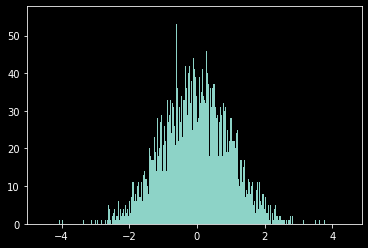

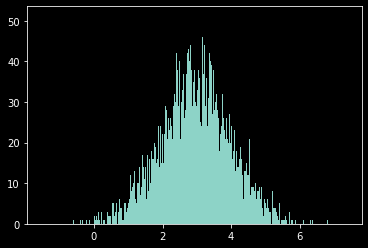

(array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 array([-3.41, -3.41, -3.41, -3.41, -3.41, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.39, -3.39, -3.39, -3.39, -3.39, -3.39, -3.39, -3.39, -3.38, -3.38, -3.38, -3.38, -3.38, -3.38, -3.38, -3.38, -3.37, ..., 9.24, 9.24, 9.24, 9.24, 9.24, 9.24, 9.24, 9.25, 9.25, 9.25, 9.25, 9.25, 9.25, 9.25, 9.25, 9.26, 9.26, 9.26, 9.26, 9.26, 9.26, 9.26, 9.26, 9.27, 9.27, 9.27, 9.27, 9.27, 9.27, 9.27]),
 <a list of 10000 Patch objects>)

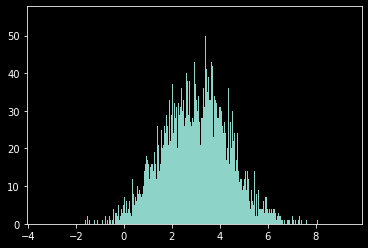

In [14]:
# model
# NUM_SESSIONS, NUM_ITEMS = len(sess_id_to_idx), len(item_id_to_idx)
# embedding_dim = 500

# session_embeddings = tf.Variable(tf.random_normal_initializer(dtype=tf.float64)([NUM_SESSIONS, embedding_dim]))
# item_embeddings = tf.Variable(tf.random_normal_initializer(dtype=tf.float64)([embedding_dim, NUM_ITEMS]))

# session_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
# item_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing

# session_embedding_columns = tf.reshape(tf.gather_nd(session_embeddings, session_slice_idxs), [-1, embedding_dim])
# item_embedding_rows = tf.reshape(tf.gather_nd(item_embeddings, session_slice_idxs), [-1, embedding_dim])

# matrix_factorization_layer = session_embedding_columns * item_embedding_rows

# pred_y = tf.nn.sigmoid(matrix_factorization_layer)